<a href="https://colab.research.google.com/github/RickBerends/Domain-Specific-BERT-for-Depression-Detection/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import re
import os
import glob
sys.path.insert(0, '/content/drive/Mijn Drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Splits')

In [ ]:
os.getcwd()

#Load train, split = 0 for train. 
df = pd.read_csv("train_split.csv", usecols=[0,1])
df['split'] = 0
df['Participant_ID'].astype(int)

#Load test split, split = 2 for test.
df1 = pd.read_csv("full_test_split copy.csv", sep=';', usecols=[0,1])
df1['split'] = 2
df1['Participant_ID'].astype(int)
df1.rename(columns = {'PHQ_Binary':'PHQ8_Binary'}, inplace = True)

#Load dev split, split = 1 for dev.
df2 = pd.read_csv("dev_split.csv", usecols=[0,1])
df2['split'] = 1
df2['Participant_ID'].astype(int)

#Get them together
final_df = pd.concat([df,df1,df2])
final_df.sort_values('Participant_ID', inplace=True)

In [ ]:
#Building data cleaning. 

import nltk
nltk.download('popular')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

def clean_text(text): 
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  text = text.lower()
  text = re.sub(r"<sync>", "",text)
  text = re.sub(r"he's", "he is", text)
  text = re.sub(r"there's", "there is", text)
  text = re.sub(r"we're", "we are", text)
  text = re.sub(r"That's", "That is", text)
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"they're", "they are", text)
  text = re.sub(r"can't", "cannot", text)
  text = re.sub(r"wasn't", "was not", text)
  text = re.sub(r"don't", "do not", text)
  text = re.sub(r"aren't", "are not", text)
  text = re.sub(r"isn't", "is not", text)
  text = re.sub(r"what's", "what is", text)
  text = re.sub(r"haven't", "have not", text)
  text = re.sub(r"hasn't", "has not", text)
  text = re.sub(r"there's", "there is", text)
  text = re.sub(r"he's", "he is", text)
  text = re.sub(r"it's", "it is", text)
  text = re.sub(r"you're", "you are", text)
  text = re.sub(r"i'm", "i am", text)
  text = re.sub(r"shouldn't", "should not", text)
  text = re.sub(r"wouldn't", "would not", text)
  text = re.sub(r"isn't", "is not", text)
  text = re.sub(r"here's", "here is", text)
  text = re.sub(r"you've", "you have", text)
  text = re.sub(r"we're", "we are", text)
  text = re.sub(r"what's", "what is", text)
  text = re.sub(r"couldn't", "could not", text)
  text = re.sub(r"we've", "we have", text)
  text = re.sub(r"it's", "it is", text)
  text = re.sub(r"doesn't", "does not", text)
  text = re.sub(r"who's", "who is", text)
  text = re.sub(r"y'all", "you all", text)
  text = re.sub(r"would've", "would have", text)
  text = re.sub(r"it'll", "it will", text)
  text = re.sub(r"we'll", "we will", text)
  text = re.sub(r"we've", "we have", text)
  text = re.sub(r"he'll", "he will", text)
  text = re.sub(r"y'all", "you all", text)
  text = re.sub(r"weren't", "Were not", text)
  text = re.sub(r"didn't", "did not", text)
  text = re.sub(r"they'll", "they will", text)
  text = re.sub(r"they'd", "they would", text)
  text = re.sub(r"don't", "do not", text)
  text = re.sub(r"they've", "they have", text)
  text = re.sub(r"i'd", "I would", text)
  text = re.sub(r"should've", "should have", text)
  text = re.sub(r"where's", "where is", text)
  text = re.sub(r"we'd", "we would", text)
  text = re.sub(r"i'll", "i will", text)
  text = re.sub(r"weren't", "were not", text)
  text = re.sub(r"they're", "they are", text)
  text = re.sub(r"let's", "let us", text)
  text = re.sub(r"it's", "it is", text)
  text = re.sub(r"can't", "cannot", text)
  text = re.sub(r"don't", "do not", text)
  text = re.sub(r"you're", "you are", text)
  text = re.sub(r"i've", "i have", text)
  text = re.sub(r"that's", "that is", text)
  text = re.sub(r"i'll", "i will", text)
  text = re.sub(r"doesn't", "does not", text)
  text = re.sub(r"i'd", "i would", text)
  text = re.sub(r"didn't", "did not", text)
  text = re.sub(r"ain't", "am not", text)
  text = re.sub(r"you'll", "you will", text)
  text = re.sub(r"i've", "i have", text)
  text = re.sub(r"Don't", "do not", text)
  text = re.sub(r"i'll", "i will", text)
  text = re.sub(r"i'd", "i would", text)
  text = re.sub(r"let's", "Let us", text)
  text = re.sub(r"you'd", "you would", text)
  text = re.sub(r"it's", "it is", text)
  text = re.sub(r"ain't", "am not", text)
  text = re.sub(r"haven't", "have not", text)
  text = re.sub(r"could've", "could have", text)
  text = re.sub(r"youve", "you have", text)  
  text = re.sub(r"[-()\"#/@;:<>.?,]","",text)
  text = ' '.join(text.split())
  text = text.split(' ')
  text = [w for w in text if not w in stop_words]
  text = [lemmatizer.lemmatize(w) for w in text]
  text = ' '.join(text)
  return text

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [ ]:
#Loading all the text from the individual transcripts into one dataframe. 
os.chdir('/content/drive/My Drive/DAICWOZ_transcripts')

lst = []
labels = []
pd.set_option('max_colwidth', 800)

for file in glob.glob("*.csv"):
    name = file
    try: 
        df = pd.read_csv(name, usecols=[2,3], sep='\t')
        outcome = df['speaker'] == 'Participant' 
        new_str = ''
    except ValueError: 
        print(name)
        continue
    for index, j in enumerate(outcome):
        if j == False: 
            continue
        else: 
            response = df['value'][index:index+1]
            response = response.to_string(index=False)
            new_str+= response
    new_str = clean_text(new_str)
    lst.append(new_str)
    labels.append(name.split('_')[0])

final_df['text'] = lst

In [ ]:
#Split the text, based on the length of the text. 

def get_split(text1): 
  l_total = []
  l_partial = []

  #Check whether or not the text is bigger than 150 words and should be split.
  if len(text1.split())//20>0:
    n = len(text1.split())//20
  else: 
    n = 1
  
  #If that's the case, the first split is smaller than 200, the next split is [150:350], [300:550] etc. 
  for w in range(n): 
    if w == 0: 
      l_partial = text1.split()[:20]
      l_total.append(" ".join(l_partial))

    else: 
      l_partial = text1.split()[w*20: w*20+ 20]
      l_total.append(" ".join(l_partial))
  return l_total

twohundred_lst = []

for i in lst: 
  twohundred_lst.append(get_split(i))

#Finally replace the "text" with text, split up in lists.
final_df['text'] = twohundred_lst

In [ ]:
final_df

,Participant_ID,PHQ8_Binary,split,text
0,300,0,2,"[yes i am doing well los angeles the greater los angeles area people diversity and various entertainment and activities um, fickle weather traffic and litter i have traveled domestically not internationally seeing other places and how people live and the, culture the last trip that i went to was san diego but uh from childhood or as an adult um, family vacations to um baja and rosarito beach yeah the reason why that memory comes to mind because um this, weekend is easter and we usually will go down to easter east easter spring break to rosarito baja um i, have a bachelor's b bachelor's in communication studies because it is a open field just does not deal with um, communication interactively but performing arts telecommunications business entrepreneurship so no i am not i am actually u..."
1,301,0,2,"[yes i am alright los angeles california yep um the lights big city it is always something going on the, traffic and that is it uh business administration and business management uh not that i am doing something else i, am doing networking at the moment sigh hmm uh to open up a big clothing line and just supply the, whole world with clothing laughter yeah definitely uh 'cause i am all about myself it is all about me laughter, not often but more times than not yeah being lied to and i guess when people think you are dumber, than you than what you are laughter uh try to get away from everything go into my own space very, well i am great at controlling my temper sigh i um probably like two days ago laughter and it was, probably just over some sports it was not a real argument sharp inhali..."
0,302,0,1,"[yeah that is perfectly fine i am feeling great uh it is an early morning i do not have school, i am excited laughter uh born and raised in los angeles california mhm uh the fact that you can surf, snowboard and like do two drastically different things in one day uh coming from the neighborhoods i have lived in, uh tisk I would say the population of uh lower socio economic backgrounds it it is like a cesspool almost, for young african americans and it sucks uh not really i have been to new york connecticut mexico and texas, but pretty young hmm laughter uh mostly if i am traveling by plane just the sight and the air is, amazing it is remarkable uh the first time i went to new york i was about eleven years old and, i made sure i got the the window seat on the plane and just the feeling ..."
0,303,0,0,"[mm maybe okay i am from california it is sun there is sunshine s sunshine weather mhm what do you, like about l_a laughter what do laughter um i like um sniff i just said i i like li like, the weather the traffic no i do not have the means i studied liberal art a art a i studied, um film because i live in los angeles not really um uh to work i i want to become a, laughter i do not care ca i do not know i i i i do not wanna tell you yeah, okay i am very outgoing because because are you outgoing laughter um sit down sleep um i think about it, and then i stop it is easy um i do not remember um for not changing the battery on my, phone no it was the battery on my car i did not change it and it did not start and, i procrastinated and so yeah yeah that is a bad word you cannot say that i no..."
1,304,0,0,"[i am doing alright uh originally i am from california uh born in glendale i am not too happy with, it uh just unemployed at the moment but uh actively seeking uh uh doing what i am supposed to be, doing uh there are some uh some prospects there but hopefully i will learn something today yeah well i have, one it is a girlfriend so i consider her a roommate a lover type thing pardon me um we are, pretty close uh i met her last year and uh we have been through some troubling times but uh we, are starting to see a light at the end of the tunnel uh the troubling times uh i would let, me see uh well i had uh gotten a d_u_i last year and uh lost my job i am a, truck driver by trade so uh that kinda 

In [ ]:
df_train = pd.DataFrame()
df_val = pd.DataFrame()
df_test = pd.DataFrame()

df_train = final_df[final_df['split'] == 0]
df_val = final_df[final_df['split'] == 1]
df_test = final_df[final_df['split'] == 2]

In [ ]:
#Copy dataframe to new dataframe
df_train_over = df_train.copy()

#Sample random rows
n = 77 - 30 

#Minority class
minor = df_train[df_train['PHQ8_Binary'] == 1]

rows = minor.sample(47, replace = True)

over_train_df = df_train_over.append(rows, ignore_index=True)
df_train = over_train_df

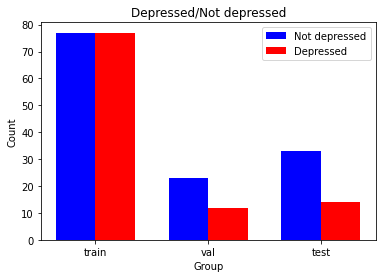

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def get_plot_count(df_train, df_val, df_test): 
  not_depressed = []
  depressed = []

  for i in (df_train, df_val, df_test):
    not_depressed.append(i.PHQ8_Binary.value_counts()[0])
    depressed.append(i.PHQ8_Binary.value_counts()[1])

  # bar charts

  n_groups = 3

  index = np.arange(n_groups)
  bar_width = 0.35

  rects1 = plt.bar(index, not_depressed, bar_width,
                  color='b',
                  label='Not depressed')

  rects2 = plt.bar(index + bar_width, depressed, bar_width,
                  color='r',
                  label='Depressed')

  plt.xlabel('Group')
  plt.ylabel('Count')
  plt.title('Depressed/Not depressed')
  plt.xticks(index + bar_width / 2, ('train', 'val', 'test'))

  plt.legend()

  return depressed

depressed = get_plot_count(df_train, df_val, df_test)

In [ ]:
"""#If I wanted to downsample to 33, 33. 
#Rather upsample > more inputs.

def downsample_df(df_train, i): 
  df_train_a = df_train[df_train['PHQ8_Binary'] == 0]
  df_train_b = df_train[df_train['PHQ8_Binary'] == 1]

  df_train_a = df_train_a.drop(df_train_a.index[depressed[i]:])
  df_train = pd.concat([df_train_a, df_train_b])
  return df_train

df_train = downsample_df(df_train, 0)"""

[77, 12, 14]

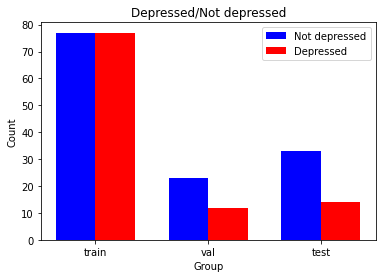

In [ ]:
get_plot_count(df_train, df_val, df_test)

In [ ]:
df_train.head()

,Participant_ID,PHQ8_Binary,split,text
0,303,0,0,[mm maybe okay california sun sunshine sunshine weather mhm like l_a laughter laughter um like um sniff said like li like weather traffic mean studied liberal art art studied um film live los angeles really um uh work want become laughter care ca know wanna tell yeah okay outgoing outgoing laughter um sit sleep um think stop easy um remember um changing battery phone battery car change start procrastinated yeah yeah bad word cannot say procrastinate something worse happen something worse happens something bad happens get worse become prepare preparation uh um prepare um think stuff last minute uh thing get thing done sigh context okay name laughter oh forgot okay um understand question elaborate give example sigh um um good question um ask question um okay sleep easy close eye tired ti...
1,304,0,0,[alright uh originally california uh born glendale happy uh unemployed moment uh actively seeking uh uh supposed uh uh prospect hopefully learn something today yeah well one girlfriend consider roommate lover type thing pardon um pretty close uh met last year uh troubling time uh starting see light end tunnel uh troubling time uh would let see uh well uh gotten d_u_i last year uh lost job truck driver trade uh kinda threw way uh fourteen hundred dollar week job uh going nothing kinda like plus losing license kinda really threw uh could um really uh found anything interested uh started cooking trying see route go far uh kind career uh choose choosing go culinary field know uh meanwhile still work hard find work uh without going school uh think today uh applied ralphs hopefully get job j...
2,305,0,0,[yeah totally fine confidential know word wo word everybody's get wild laughter pretty good hanging nice weather um recent change feeling looking laughter digitial saying uh know yeah funny um tisk always thought uh conveying emotion feeling uh like better understood human interaction opposed non human entity yeah think see mean laughter um born raised los angeles venice area mar vista specifically um um well lot like like public transportation coming uh idea certain know medical drug like marijuana prevalent know topic thought upon feel los angeles' deep culture um stay pursue art lot lot gain different community understand laughter yeah um well human mentality um hectic chaotic know lot due vehicle car freeway idea grind know yeah hectic um atmosphere human atmosphere conducive suppo...
3,310,0,0,[synch yes pretty good alexandria virginia mhm uh moved l_a uh end two thousand one yeah crazy laughter um couple time year usually like holiday hmm sigh sigh different um think lot mellow um way like suburbia nice um something comforting always like get little restless look forward coming back little action sniffle went um grad school u_s_c um bad mean program intense like first year consuming really much spare time think adjustment like laughter life made kind um easier guess also like community people went school automatically knew people know made friend stuff bad film hmm sigh uh epiphany one day um undergrad kinda floundering little bit really know wanted um one day kinda like know really excited really passionate um realized movie movie thing love passionate decided go film scho...
4,312,0,0,[yes fine indiana yes uh know maybe ten year ago never uh like cold weather l_a beautiful weather activity time new life uh reasonably easy good weather ocean always something hm uh traffic sometimes seeing new place uh visiting new people well couple year ago went catalina island birthday spent whole day uh catalina island took boat uh hopping airplane leaving indiana good okay sleeping uh filmmaker one job yet hard shy hm past um trouble making new friend let l trusting people okay uh watch t_v go movie really temper sixteen stepfather uh uh nightmare nightmare childhood involving biological father far idea uh go walk drive uh maybe day ago uh walked around block time pushing people away uh guess try

In [ ]:
os.chdir('/content/drive/My Drive')
df_train.to_csv("df_train.csv", index=False)
df_val.to_csv("df_val.csv", index=False)
df_test.to_csv("df_test.csv", index=False)


In [ ]:
test_df = pd.read_csv("df_train.csv")
test_df.head()

,Participant_ID,PHQ8_Binary,split,text
0,303,0,0,"[""mm maybe okay california sun sunshine sunshine weather mhm like l_a laughter laughter um like um sniff said like li like weather traffic mean studied liberal art art studied um film live los angeles really um uh work want become laughter care ca know wanna tell yeah okay outgoing outgoing laughter um sit sleep um think stop easy um remember um changing battery phone battery car change start procrastinated yeah yeah bad word cannot say procrastinate something worse happen something worse happens something bad happens get worse become prepare preparation uh um prepare um think stuff last minute uh thing get thing done sigh context okay name laughter oh forgot okay um understand question elaborate give example sigh um um good question um ask question um okay sleep easy close eye tired t..."
1,304,0,0,['alright uh originally california uh born glendale happy uh unemployed moment uh actively seeking uh uh supposed uh uh prospect hopefully learn something today yeah well one girlfriend consider roommate lover type thing pardon um pretty close uh met last year uh troubling time uh starting see light end tunnel uh troubling time uh would let see uh well uh gotten d_u_i last year uh lost job truck driver trade uh kinda threw way uh fourteen hundred dollar week job uh going nothing kinda like plus losing license kinda really threw uh could um really uh found anything interested uh started cooking trying see route go far uh kind career uh choose choosing go culinary field know uh meanwhile still work hard find work uh without going school uh think today uh applied ralphs hopefully get job ...
2,305,0,0,"[""yeah totally fine confidential know word wo word everybody's get wild laughter pretty good hanging nice weather um recent change feeling looking laughter digitial saying uh know yeah funny um tisk always thought uh conveying emotion feeling uh like better understood human interaction opposed non human entity yeah think see mean laughter um born raised los angeles venice area mar vista specifically um um well lot like like public transportation coming uh idea certain know medical drug like marijuana prevalent know topic thought upon feel los angeles' deep culture um stay pursue art lot lot gain different community understand laughter yeah um well human mentality um hectic chaotic know lot due vehicle car freeway idea grind know yeah hectic um atmosphere human atmosphere conducive supp..."
3,310,0,0,"[""synch yes pretty good alexandria virginia mhm uh moved l_a uh end two thousand one yeah crazy laughter um couple time year usually like holiday hmm sigh sigh different um think lot mellow um way like suburbia nice um something comforting always like get little restless look forward coming back little action sniffle went um grad school u_s_c um bad mean program intense like first year consuming really much spare time think adjustment like laughter life made kind um easier guess also like community people went school automatically knew people know made friend stuff bad film hmm sigh uh epiphany one day um undergrad kinda floundering little bit really know wanted um one day kinda like know really excited really passionate um realized movie movie thing love passionate decided go film sch..."
4,312,0,0,"[""yes fine indiana yes uh know maybe ten year ago never uh like cold weather l_a beautiful weather activity time new life uh reasonably easy good weather ocean always something hm uh traffic sometimes seeing new place uh visiting new people well couple year ago went catalina island birthday spent whole day uh catalina island took boat uh hopping airplane leaving indiana good okay sleeping uh filmmaker one job yet hard shy hm past um trouble making new friend let l trusting people okay uh watch t_v go movie really temper sixteen stepfather uh uh nightmare nightmare childhood involving biological father far idea uh go walk drive uh maybe day ago uh walked around block time pushing people away 

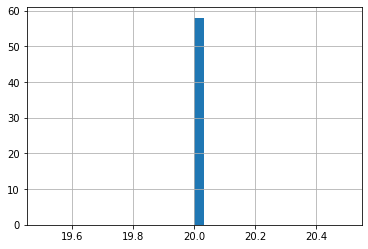

In [ ]:
##How to check length of all inputs. 
seq_len = [len(i.split()) for i in df_train.text[3]]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
def prepare_reduced_data(data):
    df = data
    df = df.set_index(pd.Series(list(range(108))))
    return df

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
class_count_df = df_train.groupby('PHQ8_Binary').count() 
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0] 
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
print(w_0, w_1) 
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

1.0 1.0


In [ ]:
def defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME):
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, truncation=True)
    return tokenizer

class GPReviewDataset(Dataset):
    
    def __init__(self, doc, targets, tokenizer, max_len):
        self.doc = doc
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.doc)
  
    def __getitem__(self, item):
        doc = str(self.doc[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
                    doc,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                    )

        return {
            'doc_text': doc,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        doc=df.text.to_numpy(),
        targets=df.PHQ8_Binary.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
        )

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
    ):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["doc_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values


In [ ]:
if __name__=="__main__":
    
    """full_data=final_df
    df=prepare_reduced_data(full_data)"""

    PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
    tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

    sample_txt=sample_txt='This is the sample text I will be using/Lets go' 

    tokens = tokenizer.tokenize(sample_txt)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    encoding = tokenizer.encode_plus(
                      sample_txt,
                      max_length=20,
                      #64
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      return_token_type_ids=False,
                      pad_to_max_length=True,
                      trunctation=True,
                      return_attention_mask=True,
                      return_tensors='pt',  # Return PyTorch tensors
                    )

    
    
    MAX_LEN = 20
    #256
    BATCH_SIZE = 32

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    data = next(iter(train_data_loader))

    bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    last_hidden_state, pooled_output = bert_model(
                    input_ids=encoding['input_ids'], 
                    attention_mask=encoding['attention_mask'])

    model = SentimentClassifier(2)
    model = model.to(device)

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)


    EPOCHS = 10

    optimizer = AdamW(model.parameters(), lr=0.00001, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss(weight = class_weights).to(device)


    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        """if val_acc > best_accuracy:
          torch.save(model.state_dict(), 'best_model_state.bin')
          best_accuracy = val_acc"""

        y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
        model,
        test_data_loader
        )

        print(classification_report(y_test, y_pred, target_names=['Not depressed', 'Depressed']))
        
        report = classification_report(y_test, y_pred, target_names=['Not depressed', 'Depressed'], output_dict=True)

        weighted_f1 = report['weighted avg']['f1-score']

        if weighted_f1 > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = weighted_f1
        
    test_acc, _ = eval_model(
          model,
          test_data_loader,
          loss_fn,
          device,
          len(df_test)
        )
    print('\nTest Accuracy:\n')
    print(test_acc.item())

    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
    )

    print(classification_report(y_test, y_pred, target_names=['Not depressed', 'Depressed']))

Epoch 1/10
----------
Train loss 0.8752265334129333 accuracy 0.38961038961038963
Val   loss 0.6252734065055847 accuracy 0.6571428571428571



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

Not depressed       0.70      1.00      0.82        33
    Depressed       0.00      0.00      0.00        14

     accuracy                           0.70        47
    macro avg       0.35      0.50      0.41        47
 weighted avg       0.49      0.70      0.58        47

Epoch 2/10
----------
Train loss 0.7976791381835937 accuracy 0.4415584415584416
Val   loss 0.5815731734037399 accuracy 0.6571428571428571

               precision    recall  f1-score   support

Not depressed       0.70      1.00      0.82        33
    Depressed       0.00      0.00      0.00        14

     accuracy                           0.70        47
    macro avg       0.35      0.50      0.41        47
 weighted avg       0.49      0.70      0.58        47

Epoch 3/10
----------
Train loss 0.7372286081314087 accuracy 0.4675324675324676
Val   loss 0.5575634092092514 accuracy 0.6571428571428571

               precision    recall  f1-score   support



In [ ]:
import matplotlib
import matplotlib.pyplot as plt

train_accuracy = history.history['train_acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['train_loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Training and Validation accuracy by epoch', fontsize=16)
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend(['Train acc', 'Val acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.title('Training and Validation loss by epoch', fontsize=16)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(['Train loss', 'Val loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.5325, device='cuda:0', dtype=torch.float64),
              tensor(0.4416, device='cuda:0', dtype=torch.float64),
              tensor(0.5195, device='cuda:0', dtype=torch.float64),
              tensor(0.5260, device='cuda:0', dtype=torch.float64),
              tensor(0.4805, device='cuda:0', dtype=torch.float64),
              tensor(0.5779, device='cuda:0', dtype=torch.float64),
              tensor(0.6429, device='cuda:0', dtype=torch.float64),
              tensor(0.8052, device='cuda:0', dtype=torch.float64),
              tensor(0.9221, device='cuda:0', dtype=torch.float64),
              tensor(0.9675, device='cuda:0', dtype=torch.float64),
              tensor(0.9935, device='cuda:0', dtype=torch.float64),
              tensor(1., device='cuda:0', dtype=torch.float64),
              tensor(1., device='cuda:0', dtype=torch.float64),
              tensor(1., device='cuda:0', dtype=torch.float64),
              tensor(1., devi

From here on and further, we are using the fine-tuned model rather than the general BERT model. 

In [ ]:
if __name__=="__main__":
    
    """full_data=final_df
    df=prepare_reduced_data(full_data)"""

    PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
    tokenizer=defining_bert_tokenizer(PRE_TRAINED_MODEL_NAME)

    sample_txt='This is the sample text I will be using/Lets go' 

    tokens = tokenizer.tokenize(sample_txt)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    encoding = tokenizer.encode_plus(
                      sample_txt,
                      max_length=200,
                      #64
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      return_token_type_ids=False,
                      pad_to_max_length=True,
                      trunctation=True,
                      return_attention_mask=True,
                      return_tensors='pt',  # Return PyTorch tensors
                    )

    
    
    MAX_LEN = 200
    #256
    BATCH_SIZE = 32

    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    data = next(iter(train_data_loader))

    bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    last_hidden_state, pooled_output = bert_model(
                    input_ids=encoding['input_ids'], 
                    attention_mask=encoding['attention_mask'])

    model = SentimentClassifier(2)

    #Load fine-tuned weights to model.
    os.chdir('/content/drive/My Drive')
    path = 'saved_weights3_1.pt'
    model.load_state_dict(torch.load(path))

    #Send model to device (GPU)
    model = model.to(device)

    #Send input and attention mask to device (GPU)
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)


    EPOCHS = 20

    optimizer = AdamW(model.parameters(), lr=0.00001, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss(weight = class_weights).to(device)


    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        """if val_acc > best_accuracy:
          torch.save(model.state_dict(), 'best_model_state.bin')
          best_accuracy = val_acc"""

        y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
        model,
        test_data_loader
        )

        print(classification_report(y_test, y_pred, target_names=['Not depressed', 'Depressed']))
        
        report = classification_report(y_test, y_pred, target_names=['Not depressed', 'Depressed'], output_dict=True)

        weighted_f1 = report['weighted avg']['f1-score']

        if weighted_f1 > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = weighted_f1
        
    test_acc, _ = eval_model(
          model,
          test_data_loader,
          loss_fn,
          device,
          len(df_test)
        )
    print('\nTest Accuracy:\n')
    print(test_acc.item())

    y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
    )

    print(classification_report(y_test, y_pred, target_names=['Not depressed', 'Depressed']))

Epoch 1/20
----------
Train loss 1.1051594257354735 accuracy 0.35064935064935066
Val   loss 0.6147240996360779 accuracy 0.6857142857142857

               precision    recall  f1-score   support

Not depressed       0.77      0.73      0.75        33
    Depressed       0.44      0.50      0.47        14

     accuracy                           0.66        47
    macro avg       0.61      0.61      0.61        47
 weighted avg       0.67      0.66      0.67        47

Epoch 2/20
----------
Train loss 0.5064523786306381 accuracy 0.6688311688311689
Val   loss 0.8374199569225311 accuracy 0.39999999999999997

               precision    recall  f1-score   support

Not depressed       0.83      0.30      0.44        33
    Depressed       0.34      0.86      0.49        14

     accuracy                           0.47        47
    macro avg       0.59      0.58      0.47        47
 weighted avg       0.69      0.47      0.46        47

Epoch 3/20
----------
Train loss 0.2842897206544876 ac

In [ ]:
os.chdir('/content/drive/My Drive')
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
os.chdir('/content/drive/My Drive')